In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv


This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

UID: unique identifier ranging from 1 to 10000

product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number

type: just the product type L, M or H from column 2

air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise

torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.

tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail. This dataset is part of the following publication, please cite when using this dataset: S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

In [2]:
raw_data = pd.read_csv('/kaggle/input/predictive-maintenance-dataset-ai4i-2020/ai4i2020.csv')
raw_data.head() #numerical & categorical cols

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

Lets first try to predict machine failure - not multiclass yet

Exploring datafrom ydata_profiling import ProfileReport

In [3]:
df = raw_data.copy()

In [4]:
df.describe(include='all') #mostly non failures, unbalanced dataset 

UDI Product ID   Type  Air temperature [K]  \
count   10000.00000      10000  10000         10000.000000   
unique          NaN      10000      3                  NaN   
top             NaN     M14860      L                  NaN   
freq            NaN          1   6000                  NaN   
mean     5000.50000        NaN    NaN           300.004930   
std      2886.89568        NaN    NaN             2.000259   
min         1.00000        NaN    NaN           295.300000   
25%      2500.75000        NaN    NaN           298.300000   
50%      5000.50000        NaN    NaN           300.100000   
75%      7500.25000        NaN    NaN           301.500000   
max     10000.00000        NaN    NaN           304.500000   

        Process temperature [K]  Rotational speed [rpm]   Torque [Nm]  \
count              10000.000000            10000.000000  10000.000000   
unique                      NaN                     NaN           NaN   
top                         NaN                     NaN           NaN   
freq                        NaN                     NaN           NaN   
mean                 310.005560             1538.776100     39.986910   
std                    1.483734              179.284096      9.968934   
min                  305.700000             1168.000000      3.800000   
25%                  308.800000             1423.000000     33.200000   
50%                  310.100000             1503.000000     40.100000   
75%                  311.100000             1612.000000     46.800000   
max                  313.800000             2886.000000     76.600000   

        Tool wear [min]  Machine failure           TWF           HDF  \
count      10000.000000     10000.000000  10000.000000  10000.000000   
unique              NaN              NaN           NaN           NaN   
top                 NaN              NaN           NaN           NaN   
freq                NaN              NaN           NaN           NaN   
mean         107.951000         0.033900      0.004600      0.011500   
std           63.654147         0.180981      0.067671      0.106625   
min            0.000000         0.000000      0.000000      0.000000   
25%           53.000000         0.000000      0.000000      0.000000   
50%          108.000000         0.000000      0.000000      0.000000   
75%          162.000000         0.000000      0.000000      0.000000   
max          253.000000         1.000000      1.000000      1.000000   

                 PWF           OSF          RNF  
count   10000.000000  10000.000000  10000.00000  
unique           NaN           NaN          NaN  
top              NaN           NaN          NaN  
freq             NaN           NaN          NaN  
mean        0.009500      0.009800      0.00190  
std         0.097009      0.098514      0.04355  
min         0.000000      0.000000      0.00000  
25%         0.000000      0.000000      0.00000  
50%         0.000000      0.000000      0.00000  
75%         0.000000      0.000000      0.00000  
max         1.000000      1.000000      1.00000

In [5]:
df.info() #no NAs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
#is product id repeating? could be risk factor if yes, if not should exclude
len(df['Product ID'].unique()) == df.shape[0]

True

In [7]:
#lets check out all cols. exclude UDI k product ID
feat_cols = df.columns[2:]
print(feat_cols)

#turn type to numberical, as it might be useful
df['Type'] = df['Type'].map({'L':0, 'M':1, 'H':2 })
df['Type'].unique() #worked


Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


array([1, 0, 2])

<Axes: >

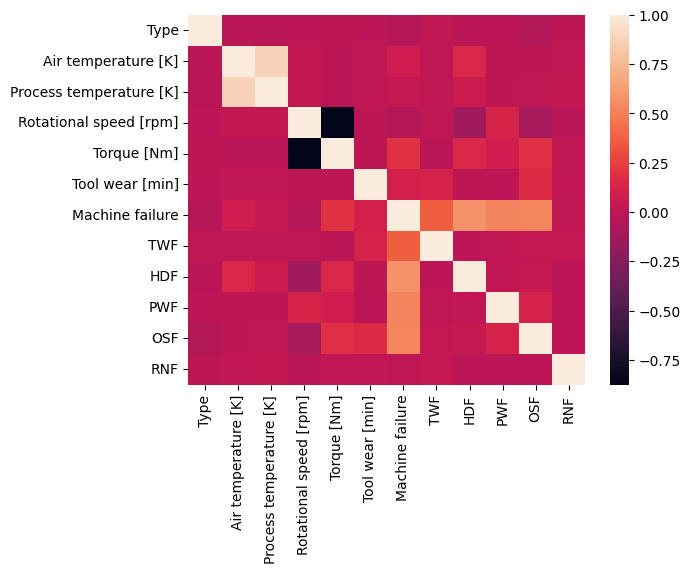

In [8]:
sns.heatmap(df[feat_cols].corr())
#air n process temp correlate strongly which makes sense since one is derived from the other. keep only one of them (air temp)
#torque & rotational speed also (negatively) correlate strongly, which alo makes sense. not great for model, maybe eep a combo of them
# machine failure veeery wekly correlates with  torque and (less with) air temp. so those stay in
#rnf useless since random. drop it

In [9]:
# lets check labels
target_cols = df.columns[8:-1]
print(target_cols)

for col in target_cols:
    print(df[col].value_counts()/df.shape[0])


#mostly machine does NOT fail, super unbalanced
# most 'rare' TWF, most 'common' HDF. can also plot bars when i have time

Index(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF'], dtype='object')
Machine failure
0    0.9661
1    0.0339
Name: count, dtype: float64
TWF
0    0.9954
1    0.0046
Name: count, dtype: float64
HDF
0    0.9885
1    0.0115
Name: count, dtype: float64
PWF
0    0.9905
1    0.0095
Name: count, dtype: float64
OSF
0    0.9902
1    0.0098
Name: count, dtype: float64


In [10]:
#lets explore this new for me thingy
from ydata_profiling import ProfileReport

profile = ProfileReport(df)
profile

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]